## Chargement des librairies utilisées

In [24]:
%matplotlib inline
import numpy as np

import matplotlib
matplotlib.rcParams['text.usetex'] = True

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import scipy as sp
from scipy import sparse
from scipy import optimize
from scipy.sparse.linalg import dsolve

## Définitions des différents algorithmes utilisés

### Algorithme de gradient à pas fixe

On implémente ici la méthode du gradient à pas fixe. 
Les arguments sont : la fonctionnelle à minimiser `f`, son gradient `df` et un point initial `x_init`. On y ajoute les arguments optionnels suivants : le pas du gradient `pas`, la tolérance demandée `tol` et le nombre maximal d'itérations `maxiter`.

On construit la suite $x_k$ définie par :

\begin{equation}
\left\{
\begin{aligned}
&x_0 \in \mathbb R^n \text{ quelconque ;} \\
&x_{k+1} = x_k - \mu \nabla J(x_k),
\end{aligned}
\right.
\end{equation}

où $\mu >0$ est le pas de l'algorithme.

In [25]:
def gradientPasFixe(f,df,x_init,pas=1e-01,tol=1e-06,maxiter=200):
    
    # initialisation
    x=x_init.copy()
    xtab=[]
    ftab=[]
    
    xtab.append(x) # on ajoute x à la liste xtab
    ftab.append(f(x))
    
    it=0 # compteur d'itération
    
    while((it==0) or (it<maxiter and np.linalg.norm(df(xtab[-1]))>tol)):
    
        x=x-pas*df(x)
        
        xtab.append(x)
        ftab.append(f(x))
        
        it=it+1
    
    # booléen pour indiquer la convergence
    if(it==maxiter) or (np.isnan(np.linalg.norm(x))==True):
        conv = False
    else:
        conv = True
    
    return xtab, ftab, conv
    

### Algorithme du gradient pas optimal

On construit la suite $x_k$ définie par :

\begin{equation}
\left\{
\begin{aligned}
&x_0 \in \mathbb R^n \text{ quelconque} \\
&x_{k+1} = x_k - \mu_k \nabla J(x_k),
\end{aligned}
\right.
\end{equation}

où le pas de descente $\mu_k$ est choisi tel que :

$$ J(x_{k+1})=\min_{\mu \in \mathbb R} J(x_k-\mu\nabla J(x_k)).$$

Lorsqu'on travaille avec une fonctionnelle quadratique  $J: \mathbb R^2 \rightarrow \mathbb R$ telle que  
$$ J(x) = \frac12 \langle Ax,x\rangle - \langle b,x\rangle,$$
avec $A$ une matrice symétrique définie positive, on sait que le pas de descente optimal est donné par 
$$\mu_k=\frac{\|r_k\|^2}{\left\langle r_k,Ar_k\right\rangle} \text{ avec } r_k= Ax_k-b.$$

On ajoute donc comme argument optionnel la variable `fct_quad` qui vaudra la matrice $A$ dans ce cas et $0$ sinon (valeur par défaut). Dans ce dernier cas, le pas optimal est trouvé en utilisant la routine "optimize.line_search" de Python.

De plus il peut être intéressant de connaître le pas optimal à chaque itération. On ajoute donc également l'argument optionnel `affichage_pas` qui permet :
- d'afficher le pas à toutes les itérations lorsque cette variable sera égale à $1$ ;
- d'afficher le pas seulement pour les 10 premières itérations lorsque cette variable sera égale à $2$ ;
- de ne pas afficher le pas lorsque cette variable est égale à $0$ (valeur par défaut).

In [26]:
def gradientPasOpt(f,df,x_init,tol=1e-06,maxiter=200,fct_quad=np.array([0]),affichage_pas=0):
    
    # initialisation
    x=x_init.copy()
    xtab=[]
    ftab=[]
    
    xtab.append(x) # on ajoute x à la liste xtab
    ftab.append(f(x))
    
    it=0 # compteur d'itération
    
    while((it==0) or (it<maxiter and np.linalg.norm(df(xtab[-1]))>tol)):
        
        if fct_quad.shape[0] > 1:            
            r=df(x)
            pas = np.dot(r,r)/np.dot(r,fct_quad@r)
        else:
            pas_opt = optimize.line_search(f,df,x,-df(x))
            pas=pas_opt[0]
            if (pas == None):
                
                raise ValueError("L algorithme line_search n a pas convergé")
        
        if (affichage_pas==1):
            print('Pas optimal = ',pas, 'à l itération ',it)
            
        elif (affichage_pas==2) and (it<10):
            print('Pas optimal = ',pas, 'à l itération ',it)
            
        x=x-pas*df(x)
        
        xtab.append(x)
        ftab.append(f(x))
        
        it=it+1
    
    # booléen pour indiquer la convergence
    if(it==maxiter) or (np.isnan(np.linalg.norm(x))==True):
        conv = False
    else:
        conv = True
    
    return xtab, ftab, conv

### Algorithme de Nesterov (fonctions convexes)

On initialise l'algorithme avec $a_0=1$ et un vecteur $y_0=x_{-1}$. Puis pour $n \geq 0$, on a :

\begin{equation}
\left\{
\begin{aligned}
x_k &= y_k - \mu \nabla J(y_k) \\
a_{k+1} &= \frac12\left(1+\sqrt{4a_k^2+1}\right) \\
y_{k+1} &= x_k + \frac{a_k - 1}{a_{k+1}}(x_k-x_{k-1})
\end{aligned}
\right.
\end{equation}



In [27]:
def gradientNesterov(f,df,x_init,pas=1e-01,tol=1e-06,maxiter=200):
    
    # initialisation
    x=x_init.copy()
    y=x_init.copy()
    x_moins=x_init.copy()
    a=1
    
    xtab=[]
    ftab=[]
    xtab.append(x) # on ajoute x à la liste xtab
    ftab.append(f(x))
    
    it=0 # compteur d'itération
   
    while((it<3) or (it<maxiter and np.linalg.norm(df(xtab[-1]))>tol)):    
        
        x=y-pas*df(y)
        anew=0.5*(1+np.sqrt(4*a+1))
        y=x+(a-1)/anew*(x-x_moins)
        
        x_moins=x
        a=anew
               
        xtab.append(x)
        ftab.append(f(x))
        it=it+1
        
    # booléen pour indiquer la convergence
    if(it==maxiter) or (np.isnan(np.linalg.norm(x))==True):
        conv = False
    else:
        conv = True
    
    return xtab, ftab, conv
    

### Algorithme de Nesterov (fonctions fortement convexes)

On initialise l'algorithme avec $1\le a_0 \le \frac1{\sqrt q}$ et un vecteur $x_0=x_{-1}$. Puis pour $n \geq 0$, on a :

\begin{equation}
\left\{
\begin{aligned}
a_{k+1} &= \frac12\left(1-qa_k^2+\sqrt{(1-qa_k^2)^2+4a_k^2}\right) \\
y_{k} &= x_k + \frac{(a_k - 1)(1-a_{k+1}\alpha\mu)}{a_{k+1}(1-\alpha\mu)}(x_k-x_{k-1})\\
x_{k+1} &= y_k - \mu \nabla J(y_k),
\end{aligned}
\right.
\end{equation}

où $\alpha$ et $L$ sont respectivement les constantes de convexité de $J$ et de Lipschitziannité de $\nabla J$ et $q=\frac{\alpha}L<1$.

Les arguments $\alpha=$ `alpha` et `L` sont donc ajoutés aux entrées de la fonction.

In [28]:
def gradientNesterov2(f,df,x_init,pas=1e-01,alpha=1,L=2,tol=1e-06,maxiter=200):
    
    # initialisation
    x=x_init.copy()
    x_moins=x_init.copy()
    a=1
    
    q=alpha/L
    
    xtab=[]
    ftab=[]
    xtab.append(x) # on ajoute x à la liste xtab
    ftab.append(f(x))
    
    it=0 # compteur d'itération
   
    while((it<3) or (it<maxiter and np.linalg.norm(df(xtab[-1]))>tol)):    
        
        anew=0.5*(1-q*a**2+np.sqrt((1-q*a**2)**2+4*a**2))
        y=x+(a-1)*(1-anew*alpha*pas)/(anew*(1-alpha*pas))*(x-x_moins)        
        x_moins=x
        x=y-pas*df(y)
       
        a=anew
               
        xtab.append(x)
        ftab.append(f(x))
        it=it+1
        
    # booléen pour indiquer la convergence
    if (it==maxiter) or (np.isnan(np.linalg.norm(x))==True):
        conv = False
    else:
        conv = True
    
    return xtab, ftab, conv
    

### Algorithme du gradient conjugué

On propose ici l'algorithme du gradient conjugué appliqué à la fonctionnelle quadratique $J: \mathbb R^2 \rightarrow \mathbb R$ telle que  
$$ J(x) = \frac12 \langle Ax,x\rangle - \langle b,x\rangle,$$
où $A\in\mathcal M_n(\mathbb R)$ est une matrice symétrique définie positive.

Dans ce cas l'algorithme s'écrit de la manière suivante :

\begin{equation}
\left\{
\begin{aligned}
 & x_0\text{ étant donné, on calcule } r_0=Au_0-b \text{ et }p_0=r_0.\\
  &\text{Pour }k=1,2,\ldots\text{, on calcule :}\\
  &\left\{
  \begin{aligned}
  \mu_k&=\frac{\|r_k\|^2}{\langle A p_k, p_k \rangle},\\
  x_{k+1}&=x_k - \mu_k p_k,\\
  r_{k+1} &= r_k - \mu_k A p_k.
 \end{aligned}
 \right.\\
 &\text{Si }\|r_k\|< \varepsilon ||b||\text{ alors on s'arrête.}\\
 &\text{Sinon }
 \left\{
\begin{aligned}
\beta_k &= \frac{\|r_{k+1}\|^2}{\|r_k\|^2},\\
 p_{k+1}&=r_{k+1} + \beta_k p_k.
\end{aligned}
\right.
 \end{aligned}
 \right.
\end{equation}

On observera que par itération seuls un produit scalaire,
deux calculs de norme et un produit matrice vecteur sont nécessaires.

In [29]:
def gradientConjugue(A,b,f,x_init,tol=1e-06,maxiter=200):
    
    # initialisation
    x=x_init.copy()
    r=A@x-b
    p=r.copy()
    
    ps_r=np.dot(r,r)
    norm_b=np.dot(b,b)
    
    xtab=[]
    ftab=[]
    xtab.append(x) # on ajoute x à la liste xtab
    ftab.append(f(x))
    
    it=0 # compteur d'itération

    while((it==0) or (it<maxiter and ps_r>tol*norm_b)):
        
        # Calcul du produit matriciel A p_k
        Ap=A@p

        # Calcul de mu_k
        mu=ps_r/np.dot(Ap,p)

        # Calcul de x_{k+1}
        x=x-mu*p

        # Calcul de r_{k+1}
        r=r-mu*Ap

        # Calcul du produit scalaire <r_{k+1},r_{k+1}> 
        ps_rnew=np.dot(r,r)

        # Calcul de beta_{k+1}
        beta=ps_rnew/ps_r

        # Calcul de p_{k+1}
        p=r+beta*p

        # On met à jour la valeur du produit scalaire <r_k,z_k>
        ps_r=ps_rnew
        
        xtab.append(x)
        ftab.append(f(x))
        it=it+1
    # booléen pour indiquer la convergence
    if(it==maxiter) or (np.isnan(np.linalg.norm(x))==True):
        conv = False
    else:
        conv = True
    
    return xtab, ftab, conv
    

### Algorithme de Newton

On applique l'algorithme de Newton à la fonction $\nabla J$.
On construit alors la suite $x_k$ définie par :
\begin{equation}
\left\{
\begin{aligned}
&x_0 \in \mathbb R^n \text{ quelconque} \\
&x_{k+1} = x_k - (H_J(x_k))^{-1} \nabla J(x_k),
\end{aligned}
\right.
\end{equation}
où $H_J$ est la hessienne de $J$.

In [30]:
def Newton(f,df,Hf,x_init,tol=1e-06,maxiter=200):
    # initialisation
    x=x_init.copy()
    xtab=[]
    ftab=[]
    xtab.append(x) # on ajoute x à la liste xtab
    ftab.append(f(x))
    it=0 # compteur d'itération
    
    while((it==0) or (it<maxiter and np.abs(f(xtab[-1])-f(xtab[-2]))>tol)):
        if (1*sp.sparse.issparse(Hf(x)))==1:
            x=x-dsolve.spsolve(Hf(x).tocsc(),df(x))
            
        else:
            x=x-np.linalg.solve(Hf(x), df(x))
            

        xtab.append(x)
        ftab.append(f(x))
        it=it+1
    # booléen pour indiquer la convergence
    if(it==maxiter) or (np.isnan(np.linalg.norm(x))==True):
        conv = False
    else:
        conv = True
   
    return xtab, ftab, conv


## Exemples d'application

### Application à une fonctionnelle quadratique 

On applique dans un premier temps ces différents algorithmes à la fonctionnelle quadratique $J: \mathbb R^N \rightarrow \mathbb R$ telle que  
$$ J(x) = \frac12 \langle Ax,x\rangle - \langle b,x\rangle,$$
avec :
\begin{equation}
 A=\frac 1 {h^2} 
 \begin{pmatrix}
 2&-1&0&\ldots&0\\
 -1&2&-1&\ddots&\vdots\\
 0&\ddots&\ddots&\ddots&0\\
\vdots&\ddots& -1&2&-1\\
0&\ldots& 0& -1&2
\end{pmatrix} \in \mathcal M _{n}(\mathbb R)\quad
\text{ et } \quad
 b=\begin{pmatrix}
1\\ \vdots\\1 \end{pmatrix}.
\end{equation}

Trouver le minimum de la fonctionnelle $J$ revient alors à résoudre le système linéaire $Ax=b$.

#### Premiers tests sur le gradient à pas fixe

In [31]:
## On construit la matrice A et le vecteur b
N=20
#N=50 # en 50 000 itérations ça n'a pas convergé (matrice mal conditionnée)
h=0.1
A_Lap= (1/h**2)*sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(N,N))
b_Lap=np.ones(N)

## On calcule la solution exacte pour vérifier la convergence de l'algorithme
sol_Lap=dsolve.spsolve(A_Lap.tocsc(), b_Lap, use_umfpack=True)

## Définition de la fonctionnelle et de sa dérivée
def J_Lap(x):
    return 0.5*np.dot(x,A_Lap*x)-np.dot(b_Lap,x)

def gradJ_Lap(x):
    return A_Lap*x-b_Lap

x_init_Lap=np.random.randn(N)

Algorithme du gradient à pas fixe avec un pas =  0.00502
Erreur =  2.508698180359236e-09
Convergence = True
Nombre d itérations =  5686
Algorithme du gradient à pas fixe avec un pas =  0.00501
Erreur =  2.5082287892810364e-09
Convergence = True
Nombre d itérations =  2536
Algorithme du gradient à pas fixe avec un pas =  0.005
Erreur =  2.78482522031915e-08
Convergence = True
Nombre d itérations =  1630
Algorithme du gradient à pas fixe avec un pas =  0.001
Erreur =  4.466716375513927e-07
Convergence = True
Nombre d itérations =  6944
Algorithme du gradient à pas fixe avec un pas =  0.0005
Erreur =  4.475554959232283e-07
Convergence = True
Nombre d itérations =  13894
Algorithme du gradient à pas fixe avec un pas =  0.00025
Erreur =  4.47496929231057e-07
Convergence = True
Nombre d itérations =  27796
Algorithme du gradient à pas fixe avec un pas =  0.0001
Erreur =  3.49090711198131e-05
Convergence = False
Nombre d itérations =  50000


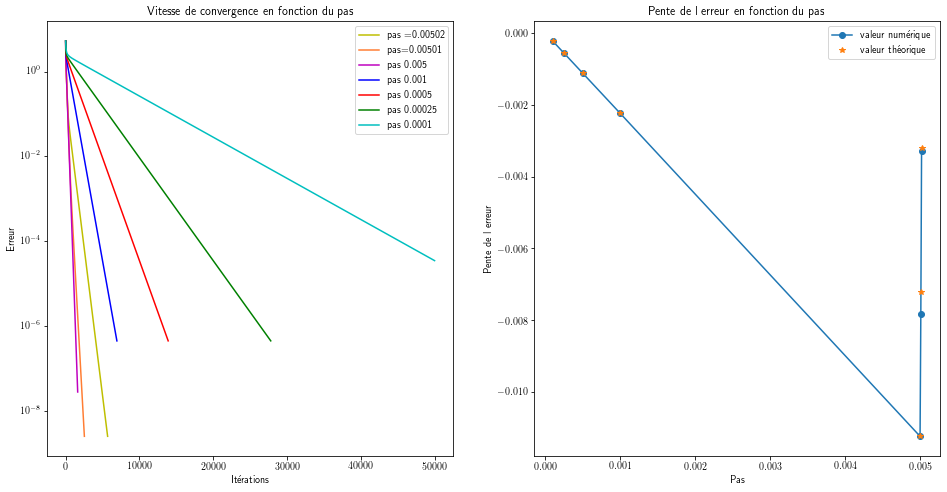

In [32]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16, 8))
v_slope=[]
v_pas=[]

## Tests avec des pas choisis arbitrairement

pas=0.00502
print('=================================')
print('Algorithme du gradient à pas fixe avec un pas = ',pas)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)
ax1.semilogy(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1),'-y',label='pas ='+str(pas))
slope, intercept = np.polyfit(np.arange(np.shape(x_PasFixe_Lap)[0]), np.log(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1)), 1)
v_slope.append(slope)
v_pas.append(pas)

pas=0.00501
print('=================================')
print('Algorithme du gradient à pas fixe avec un pas = ',pas)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)
ax1.semilogy(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1),color='#ff7d33',label='pas='+str(pas))
slope, intercept = np.polyfit(np.arange(np.shape(x_PasFixe_Lap)[0]), np.log(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1)), 1)
v_slope.append(slope)
v_pas.append(pas)

pas=0.005
print('=================================')
print('Algorithme du gradient à pas fixe avec un pas = ',pas)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)
ax1.semilogy(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1),'-m',label='pas 0.005')
slope, intercept = np.polyfit(np.arange(np.shape(x_PasFixe_Lap)[0]), np.log(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1)), 1)
v_slope.append(slope)
v_pas.append(pas)


pas=0.001
print('=================================')
print('Algorithme du gradient à pas fixe avec un pas = ',pas)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)
ax1.semilogy(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1),'-b',label='pas 0.001')
slope, intercept = np.polyfit(np.arange(np.shape(x_PasFixe_Lap)[0]), np.log(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1)), 1)
v_slope.append(slope)
v_pas.append(pas)


pas=0.0005
print('=================================')
print('Algorithme du gradient à pas fixe avec un pas = ',pas)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)
ax1.semilogy(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1),'-r',label='pas 0.0005')
slope, intercept = np.polyfit(np.arange(np.shape(x_PasFixe_Lap)[0]), np.log(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1)), 1)
v_slope.append(slope)
v_pas.append(pas)

pas=0.00025
print('=================================')
print('Algorithme du gradient à pas fixe avec un pas = ',pas)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)
ax1.semilogy(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1),'-g',label='pas 0.00025')
slope, intercept = np.polyfit(np.arange(np.shape(x_PasFixe_Lap)[0]), np.log(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1)), 1)
v_slope.append(slope)
v_pas.append(pas)


pas=0.0001
print('=================================')
print('Algorithme du gradient à pas fixe avec un pas = ',pas)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)
ax1.semilogy(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1),'-c',label='pas 0.0001')
slope, intercept = np.polyfit(np.arange(np.shape(x_PasFixe_Lap)[0]), np.log(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1)), 1)
v_slope.append(slope)
v_pas.append(pas)


ax1.set_title('Vitesse de convergence en fonction du pas')
ax1.set_ylabel('Erreur')
ax1.set_xlabel('Itérations')
ax1.legend()

vp,_=np.linalg.eigh(A_Lap.todense())
vp_max=np.max(vp)
vp_min=np.min(vp)
v_gamma=np.maximum(np.abs(1-v_pas*np.full(shape=7,fill_value=vp_min)),np.abs(1-v_pas*np.full(shape=7,fill_value=vp_max)))

ax2.plot(v_pas,v_slope,'o-',label='valeur numérique')
ax2.plot(v_pas,np.log(v_gamma),'*',label='valeur théorique')

ax2.set_title('Pente de l erreur en fonction du pas')
ax2.set_xlabel('Pas')
ax2.set_ylabel('Pente de l erreur')
ax2.legend()

plt.show()


Algorithme du gradient à pas fixe avec un pas =  0.0052


/home/flore/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app


Erreur =  nan
Convergence = False
Nombre d itérations =  10683
Algorithme du gradient à pas fixe avec un pas =  0.0051
Erreur =  nan
Convergence = False
Nombre d itérations =  25050


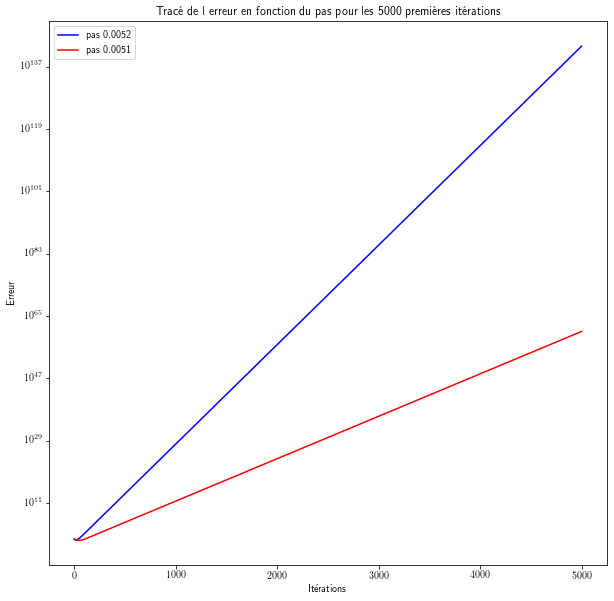

In [33]:
fig=plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

## Test avec un pas légèrement plus grand que 0.05
pas=0.0052
print('=================================')
print('Algorithme du gradient à pas fixe avec un pas = ',pas)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)
ax.semilogy(np.arange(5000),np.linalg.norm(x_PasFixe_Lap[:5000]-sol_Lap,axis=1),'-b',label='pas 0.0052')


pas=0.0051
print('=================================')
print('Algorithme du gradient à pas fixe avec un pas = ',pas)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)
ax.semilogy(np.arange(5000),np.linalg.norm(x_PasFixe_Lap[:5000]-sol_Lap,axis=1),'-r',label='pas 0.0051')

ax.set_title('Tracé de l erreur en fonction du pas pour les 5000 premières itérations')
ax.set_ylabel('Erreur')
ax.set_xlabel('Itérations')
ax.legend()

plt.show()

In [34]:
## Test avec le pas donnant la meilleure vitesse de convergence

# Calcul des valeurs propres de la matrice A
vp,_=np.linalg.eigh(A_Lap.todense())
vp_max=np.max(vp)
vp_min=np.min(vp)
pas = 2/(vp_min+vp_max)
pas_max = 2/vp_max
print('vp_min = ',vp_min)
print('vp_max = ',vp_max)

print('=================================')
print('Algorithme du gradient le pas donnant la meilleure vitesse de convergence')
print('Pas =',pas)
print('Pas_max=',pas_max)
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)

vp_min =  2.2338347549742035
vp_max =  397.7661652450256
Algorithme du gradient le pas donnant la meilleure vitesse de convergence
Pas = 0.005000000000000002
Pas_max= 0.005028079748230953
Erreur =  2.7848251813759673e-08
Convergence = True
Nombre d itérations =  1630


#### Comparaison des différents algortithmes

Dans ce cas on choisit les pas donnant les meilleures vitesses de convergence pour tous les algorithmes et on trace l'erreur entre la solution exacte et la solution approchée en fonction du nombre d'itérations dans chacun des cas.

In [35]:
pas_fixe = 2/(vp_min+vp_max)
pas_Nesterov = 1/vp_max

print('=================================')
print('Algorithme du gradient à pas fixe')
x_PasFixe_Lap, f_PasFixe, conv_PasFixe = gradientPasFixe(J_Lap,gradJ_Lap,x_init_Lap,pas_fixe,1e-6,5000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasFixe_Lap[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_Lap)[0]-1)

print('=================================')
print('Algorithme du gradient à pas optimal')
x_PasOpt_Lap, f_PasOpt, conv_PasOpt = gradientPasOpt(J_Lap,gradJ_Lap,x_init_Lap,1e-6,5000,A_Lap,2)
print('Erreur = ',np.linalg.norm(sol_Lap-x_PasOpt_Lap[-1]))
print('Convergence =',conv_PasOpt)
print('Nombre d itérations = ',np.shape(x_PasOpt_Lap)[0]-1)

print('=================================')
print('Algorithme de Nesterov')
x_Nesterov_Lap, f_Nesterov, conv_Nesterov = gradientNesterov(J_Lap,gradJ_Lap,x_init_Lap,pas_Nesterov,1e-6,5000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_Nesterov_Lap[-1]))
print('Convergence =',conv_Nesterov)
print('Nombre d itérations = ',np.shape(x_Nesterov_Lap)[0]-1)

print('=================================')
print('Algorithme de Nesterov - Deuxième version')
x_Nesterov2_Lap, f_Nesterov2, conv_Nesterov2 = gradientNesterov2(J_Lap,gradJ_Lap,x_init_Lap,pas_Nesterov,vp_min,vp_max,1e-6,5000)
print('Erreur = ',np.linalg.norm(sol_Lap-x_Nesterov2_Lap[-1]))
print('Convergence =',conv_Nesterov2)
print('Nombre d itérations = ',np.shape(x_Nesterov2_Lap)[0]-1)

print('=================================')
print('Algorithme du gradient conjugué')
x_Conj_Lap, f_Conj, conv_Conj = gradientConjugue(A_Lap,b_Lap,J_Lap,x_init_Lap,tol=1e-06,maxiter=200)
print('Erreur = ',np.linalg.norm(sol_Lap-x_Conj_Lap[-1]))
print('Convergence =', conv_Conj)
print('Nombre d itérations = ',np.shape(x_Conj_Lap)[0]-1)


def HessJ_Lap(x):
    return A_Lap

print('=================================')
print('Algorithme de Newton')
x_Newton_Lap, f_Newton, conv_Newton = Newton(J_Lap,gradJ_Lap,HessJ_Lap,x_init_Lap,tol=1e-06,maxiter=200)
print('Erreur = ',np.linalg.norm(sol_Lap-x_Newton_Lap[-1]))
print('Convergence =',conv_Newton)
print('Nombre d itérations = ',np.shape(x_Newton_Lap)[0]-1)


Algorithme du gradient à pas fixe
Erreur =  2.7848251813759673e-08
Convergence = True
Nombre d itérations =  1630
Algorithme du gradient à pas optimal
Pas optimal =  0.0036827590980693776 à l itération  0
Pas optimal =  0.004170262798143628 à l itération  1
Pas optimal =  0.003980358185477377 à l itération  2
Pas optimal =  0.004550760127161927 à l itération  3
Pas optimal =  0.004335260338016341 à l itération  4
Pas optimal =  0.004840606198082349 à l itération  5
Pas optimal =  0.004474226088015586 à l itération  6
Pas optimal =  0.004947740804713977 à l itération  7
Pas optimal =  0.004545959294734881 à l itération  8
Pas optimal =  0.005024480000703564 à l itération  9
Erreur =  3.237474992378543e-07
Convergence = True
Nombre d itérations =  1409
Algorithme de Nesterov
Erreur =  4.4509388633336526e-07
Convergence = True
Nombre d itérations =  1369
Algorithme de Nesterov - Deuxième version
Erreur =  4.3190430509284825e-07
Convergence = True
Nombre d itérations =  252
Algorithme du g

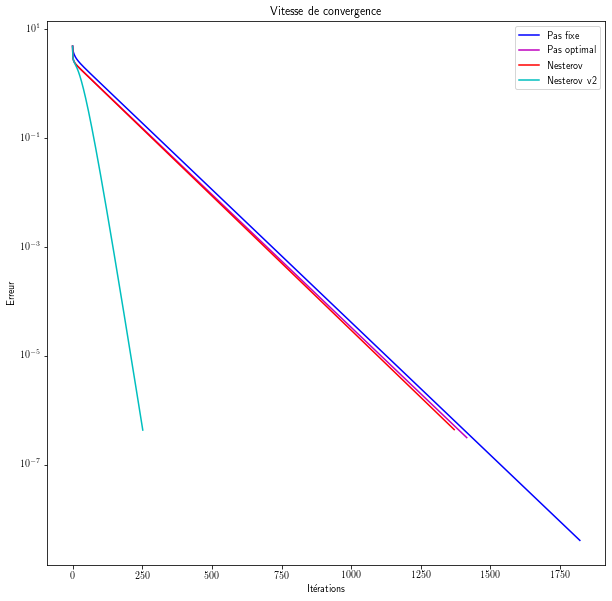

In [13]:
plt.figure(figsize=(10, 10))
plt.semilogy(np.linalg.norm(x_PasFixe_Lap-sol_Lap,axis=1),'-b')
plt.semilogy(np.linalg.norm(x_PasOpt_Lap-sol_Lap,axis=1),'-m')
plt.semilogy(np.linalg.norm(x_Nesterov_Lap-sol_Lap,axis=1),'-r')
plt.semilogy(np.linalg.norm(x_Nesterov2_Lap-sol_Lap,axis=1),'-c')
plt.legend(['Pas fixe','Pas optimal','Nesterov','Nesterov v2'])
plt.title('Vitesse de convergence')
plt.xlabel('Itérations')
plt.ylabel('Erreur')
plt.show()

On veut maintenant observer la convergence du critère d'arrêt. On trace donc $\|\nabla J(x_k)\|$ en fonction du nombre d'itérations.

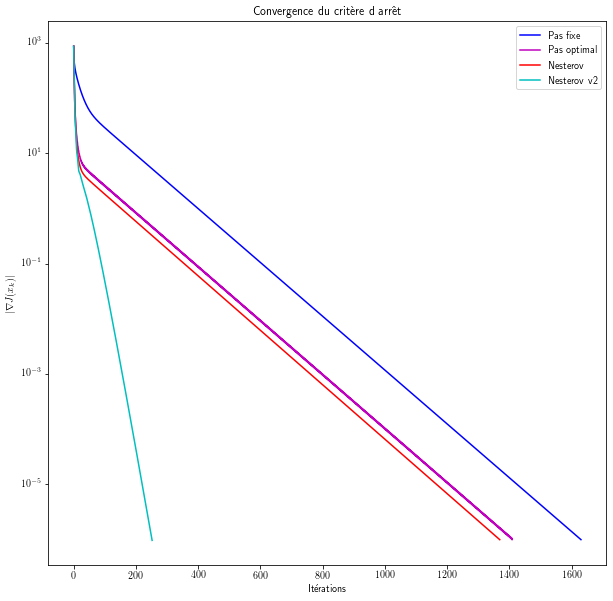

In [36]:
plt.figure(figsize=(10, 10))
plt.semilogy(np.linalg.norm([gradJ_Lap(x_PasFixe_Lap[j]) for j in range(np.shape(x_PasFixe_Lap)[0])],axis=1),'-b')
plt.semilogy(np.linalg.norm([gradJ_Lap(x_PasOpt_Lap[j]) for j in range(np.shape(x_PasOpt_Lap)[0])],axis=1),'-m')
plt.semilogy(np.linalg.norm([gradJ_Lap(x_Nesterov_Lap[j]) for j in range(np.shape(x_Nesterov_Lap)[0])],axis=1),'-r')
plt.semilogy(np.linalg.norm([gradJ_Lap(x_Nesterov2_Lap[j]) for j in range(np.shape(x_Nesterov2_Lap)[0])],axis=1),'-c')
plt.legend(['Pas fixe','Pas optimal','Nesterov','Nesterov v2'])
plt.title('Convergence du critère d arrêt')
plt.xlabel('Itérations')
plt.ylabel(r'$| \nabla J(x_k)|$')
plt.show()


### Matrices à spectre fixé

On étudie la vitesse de convergence pour des matrices de taille croissante mais ayant toujours le même spectre de valeurs propres

============= N =  50 =============
Algorithme du gradient à pas fixe
Erreur =  3.135775323893898e-07
Convergence = True
Nombre d itérations =  35
Algorithme du gradient à pas optimal
Erreur =  2.3444852871636146e-07
Convergence = True
Nombre d itérations =  34
Algorithme de Nesterov
Erreur =  3.6744216582401835e-07
Convergence = True
Nombre d itérations =  33
Algorithme de Nesterov - Deuxième version
Erreur =  1.9020121162934852e-07
Convergence = True
Nombre d itérations =  28
Algorithme du gradient conjugué
Erreur =  0.0008025912766367725
Convergence = True
Nombre d itérations =  9
Algorithme de Newton
Erreur =  9.548806803446935e-16
Convergence = True
Nombre d itérations =  2
============= N =  100 =============
Algorithme du gradient à pas fixe
Erreur =  3.118487388527886e-07
Convergence = True
Nombre d itérations =  40
Algorithme du gradient à pas optimal
Erreur =  2.9882032504297246e-07
Convergence = True
Nombre d itérations =  40
Algorithme de Nesterov
Erreur =  3.31699571852704

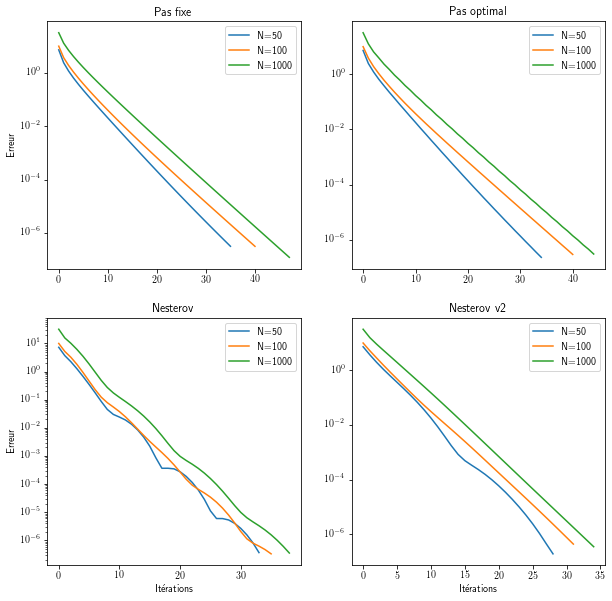

In [37]:
fig, [[ax1, ax2],[ax3,ax4]] = plt.subplots(nrows=2, ncols=2,figsize=(10, 10))

for N in np.array([50,100,1000]):
    H = np.random.randn(N,N)
    mat_Q, R = sp.linalg.qr(H)

    vp=2+9*np.random.random(N)
    
    mat_A = sparse.diags(vp,shape=(N,N)) 
    mat_A = mat_Q.T@mat_A@mat_Q

    
    b_spec=np.ones(N)
    
    def J_spec(x):
        return 0.5*np.dot(x,mat_A@x)-np.dot(b_spec,x)

    def gradJ_spec(x):
        return mat_A@x-b_spec
    
    
    sol_spec=np.linalg.solve(mat_A, b_spec)


    x_init=np.random.randn(N)
    
    print('============= N = ', N ,'=============')

    print('=================================')
    print('Algorithme du gradient à pas fixe')
    x_PasFixe_spec, f_PasFixe, conv_PasFixe = gradientPasFixe(J_spec,gradJ_spec,x_init,2/13,1e-6,50000)
    print('Erreur = ',np.linalg.norm(sol_spec-x_PasFixe_spec[-1]))
    print('Convergence =',conv_PasFixe)
    print('Nombre d itérations = ',np.shape(x_PasFixe_spec)[0]-1)

    print('=================================')
    print('Algorithme du gradient à pas optimal')
    x_PasOpt_spec, f_PasOpt, conv_PasOpt = gradientPasOpt(J_spec,gradJ_spec,x_init,1e-6,50000,mat_A)
    print('Erreur = ',np.linalg.norm(sol_spec-x_PasOpt_spec[-1]))
    print('Convergence =',conv_PasOpt)
    print('Nombre d itérations = ',np.shape(x_PasOpt_spec)[0]-1)

    print('=================================')
    print('Algorithme de Nesterov')
    x_Nesterov_spec, f_Nesterov, conv_Nesterov = gradientNesterov(J_spec,gradJ_spec,x_init,1/11,1e-6,5000)
    print('Erreur = ',np.linalg.norm(sol_spec-x_Nesterov_spec[-1]))
    print('Convergence =',conv_Nesterov)
    print('Nombre d itérations = ',np.shape(x_Nesterov_spec)[0]-1)

    print('=================================')
    print('Algorithme de Nesterov - Deuxième version')
    x_Nesterov2_spec, f_Nesterov2, conv_Nesterov2 = gradientNesterov2(J_spec,gradJ_spec,x_init,1/11,2,11,1e-6,50000)
    print('Erreur = ',np.linalg.norm(sol_spec-x_Nesterov2_spec[-1]))
    print('Convergence =',conv_Nesterov2)
    print('Nombre d itérations = ',np.shape(x_Nesterov2_spec)[0]-1)


    x_Conj_spec, f_Conj, conv_Conj = gradientConjugue(mat_A,b_spec,J_spec,x_init,tol=1e-06,maxiter=200)
    print('=================================')
    print('Algorithme du gradient conjugué')
    print('Erreur = ',np.linalg.norm(sol_spec-x_Conj_spec[-1]))
    print('Convergence =', conv_Conj)
    print('Nombre d itérations = ',np.shape(x_Conj_spec)[0]-1)

    def HessJ_spec(x):
        return mat_A

    print('=================================')
    print('Algorithme de Newton')
    x_Newton_spec, f_Newton, conv_Newton = Newton(J_spec,gradJ_spec,HessJ_spec,x_init,tol=1e-06,maxiter=200)
    print('Erreur = ',np.linalg.norm(sol_spec-x_Newton_spec[-1]))
    print('Convergence =',conv_Newton)
    print('Nombre d itérations = ',np.shape(x_Newton_spec)[0]-1)
    
    ax1.semilogy(np.linalg.norm(x_PasFixe_spec-sol_spec,axis=1),label='N='+str(N))   
    ax2.semilogy(np.linalg.norm(x_PasOpt_spec-sol_spec,axis=1),label='N='+str(N))
    ax3.semilogy(np.linalg.norm(x_Nesterov_spec-sol_spec,axis=1),label='N='+str(N))
    ax4.semilogy(np.linalg.norm(x_Nesterov2_spec-sol_spec,axis=1),label='N='+str(N))
    
ax1.set_title('Pas fixe')
ax2.set_title('Pas optimal')
ax3.set_title('Nesterov')
ax4.set_title('Nesterov v2')

ax1.set_ylabel('Erreur')
ax3.set_ylabel('Erreur')

ax3.set_xlabel('Itérations')
ax4.set_xlabel('Itérations')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.show()

  

### Une fonctionnelle d'ordre 4

\begin{equation}
J(x) =  \frac12 \|x\|^2 \left\langle Ax,x\right\rangle
\end{equation}

In [38]:
N=20
h=1
A= (1/h**2)*sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(N,N))


def J(x):
    return 0.5*np.dot(x,x)*np.dot(x,A*x)

def gradJ(x):
    return np.dot(x,x)*A*x+np.dot(A*x,x)*x

sol=np.zeros(N)


x_init=np.random.randn(N)

print('=================================')
print('Algorithme du gradient à pas fixe')
x_PasFixe, f_PasFixe, conv_PasFixe = gradientPasFixe(J,gradJ,x_init,0.01,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol-x_PasFixe[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe)[0]-1)

print('=================================')
print('Algorithme du gradient à pas optimal')
x_PasOpt, f_PasOpt, conv_PasOpt = gradientPasOpt(J,gradJ,x_init,1e-6,50000,np.array([0]),1)
print('Erreur = ',np.linalg.norm(sol-x_PasOpt[-1]))
print('Convergence =',conv_PasOpt)
print('Nombre d itérations = ',np.shape(x_PasOpt)[0]-1)

print('=================================')
print('Algorithme de Nesterov')
x_Nesterov, f_Nesterov, conv_Nesterov = gradientNesterov(J,gradJ,x_init,0.01,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol-x_Nesterov[-1]))
print('Convergence =',conv_Nesterov)
print('Nombre d itérations = ',np.shape(x_Nesterov)[0]-1)

print('=================================')
print('Algorithme de Nesterov - Deuxième version')
vp,_=np.linalg.eigh(A.todense())
x_Nesterov2, f_Nesterov2, conv_Nesterov2 = gradientNesterov2(J,gradJ,x_init,0.01,np.min(vp),np.max(vp),1e-6,50000)
print('Erreur = ',np.linalg.norm(sol-x_Nesterov2[-1]))
print('Convergence =',conv_Nesterov2)
print('Nombre d itérations = ',np.shape(x_Nesterov2)[0]-1)

def HessJ(x):
    return np.dot(x,x)*A+2*A*x*x.T+np.dot(A*x,x)*sp.sparse.identity(N)+2*x*x.T*A
    

print('=================================')
print('Algorithme de Newton')
x_Newton, f_Newton, conv_Newton = Newton(J,gradJ,HessJ,x_init,tol=1e-06,maxiter=200)
print('Erreur = ',np.linalg.norm(sol-x_Newton[-1]))
print('Convergence =',conv_Newton)
print('Nombre d itérations = ',np.shape(x_Newton)[0]-1)

Algorithme du gradient à pas fixe
Erreur =  0.14256981986202594
Convergence = False
Nombre d itérations =  50000
Algorithme du gradient à pas optimal
Pas optimal =  0.03748157476216565 à l itération  0
Pas optimal =  0.08271369787881747 à l itération  1
Pas optimal =  0.19862876010663963 à l itération  2
Pas optimal =  1.0 à l itération  3
Pas optimal =  1.0 à l itération  4
Pas optimal =  1.0 à l itération  5
Pas optimal =  1.0 à l itération  6
Pas optimal =  1.0 à l itération  7
Pas optimal =  1.0 à l itération  8
Pas optimal =  1.0 à l itération  9
Pas optimal =  1.0 à l itération  10
Pas optimal =  1.0 à l itération  11
Pas optimal =  1.0 à l itération  12
Pas optimal =  1.0 à l itération  13
Pas optimal =  2.0 à l itération  14
Pas optimal =  2.0 à l itération  15
Pas optimal =  2.0 à l itération  16
Pas optimal =  2.0 à l itération  17
Pas optimal =  2.0 à l itération  18
Pas optimal =  2.0 à l itération  19
Pas optimal =  2.0 à l itération  20
Pas optimal =  4.0 à l itération  2

/home/flore/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/flore/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Erreur =  0.10319368550667701
Convergence = False
Nombre d itérations =  50000
Algorithme de Nesterov - Deuxième version
Erreur =  0.0414426174156753
Convergence = False
Nombre d itérations =  50000
Algorithme de Newton
Erreur =  0.044925692291522615
Convergence = True
Nombre d itérations =  12


### Fonction non-différentiable

On étudie les algorithmes de gradient sur la fonctionnelle $$J(x)=\|x\|_1=\sum_{i=1}^N |x_i|.$$


In [42]:
def J_norm1(x):
    return np.linalg.norm(x,1)

def gradJ_norm1(x):
    return np.sign(x)

N=20
sol=np.zeros(N)
x_init=np.random.randn(N)


print('=================================')
print('Algorithme du gradient à pas fixe')
x_PasFixe_norm1, f_PasFixe, conv_PasFixe = gradientPasFixe(J_norm1,gradJ_norm1,x_init,0.01,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol-x_PasFixe_norm1[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_norm1)[0]-1)

print('=================================')
print('Algorithme de Nesterov')
x_Nesterov_norm1, f_Nesterov, conv_Nesterov = gradientNesterov(J_norm1,gradJ_norm1,x_init,0.01,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol-x_Nesterov_norm1[-1]))
print('Convergence =',conv_Nesterov)
print('Nombre d itérations = ',np.shape(x_Nesterov_norm1)[0]-1)

print('=================================')
print('Algorithme de Nesterov - Deuxième version')
x_Nesterov2_norm1, f_Nesterov2, conv_Nesterov2 = gradientNesterov2(J_norm1,gradJ_norm1,x_init,0.01,0.5,8,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol-x_Nesterov2_norm1[-1]))
print('Convergence =',conv_Nesterov2)
print('Nombre d itérations = ',np.shape(x_Nesterov2_norm1)[0]-1)

print('=================================')
print('Algorithme du gradient à pas optimal')
x_PasOpt_norm1, f_PasOpt, conv_PasOpt = gradientPasOpt(J_norm1,gradJ_norm1,x_init,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol-x_PasOpt_norm1[-1]))
print('Convergence =',conv_PasOpt)
print('Nombre d itérations = ',np.shape(x_PasOpt_norm1)[0]-1)



Algorithme du gradient à pas fixe
Erreur =  0.022558775388189175
Convergence = False
Nombre d itérations =  50000
Algorithme de Nesterov
Erreur =  0.024923481233244373
Convergence = False
Nombre d itérations =  50000
Algorithme de Nesterov - Deuxième version
Erreur =  0.02871143067197115
Convergence = False
Nombre d itérations =  50000
Algorithme du gradient à pas optimal


ValueError: L algorithme line_search n a pas convergé

In [ ]:
plt.figure(figsize=(14, 5))
plt.clf()

plt.subplot(1,3,1)   
plt.semilogy(np.linalg.norm(x_PasFixe_norm1-sol,axis=1),'b')
plt.title('Pas fixe')
plt.xlabel('Itérations')
plt.ylabel('Erreur')

plt.subplot(1,3,2)
plt.semilogy(np.linalg.norm(x_Nesterov_norm1-sol,axis=1),'r')
plt.title('Nesterov')
plt.xlabel('Itérations')

       
plt.subplot(1,3,3)
plt.semilogy(np.linalg.norm(x_Nesterov2_norm1-sol,axis=1),'c')
plt.title('Nesterov v2')
plt.xlabel('Itérations')

  


plt.figure(figsize=(14, 5))

plt.subplot(1,3,1)   
plt.semilogy(np.arange(1000,1200),np.linalg.norm(x_PasFixe_norm1-sol,axis=1)[1000:1200],'+b')
plt.title('Pas fixe')
plt.xlabel('Itérations')
plt.ylabel('Erreur')

plt.subplot(1,3,2)
plt.semilogy(np.arange(1000,1200),np.linalg.norm(x_Nesterov_norm1-sol,axis=1)[1000:1200],'+r')
plt.title('Nesterov')
plt.xlabel('Itérations')

       
plt.subplot(1,3,3)
plt.semilogy(np.arange(1000,1200),np.linalg.norm(x_Nesterov2_norm1-sol,axis=1)[1000:1200],'+c')
plt.title('Nesterov v2')
plt.xlabel('Itérations')


plt.suptitle('Zoom sur 200 itérations', fontsize=16)
  
plt.show()

## Quelques contre-exemples

### Fonction de Rosenbrock

$$
f(x)=\sum_{i=1}^{N-1} 100(x_{i+1}-x_i^2)^2 +(1-x_i)^2.
$$


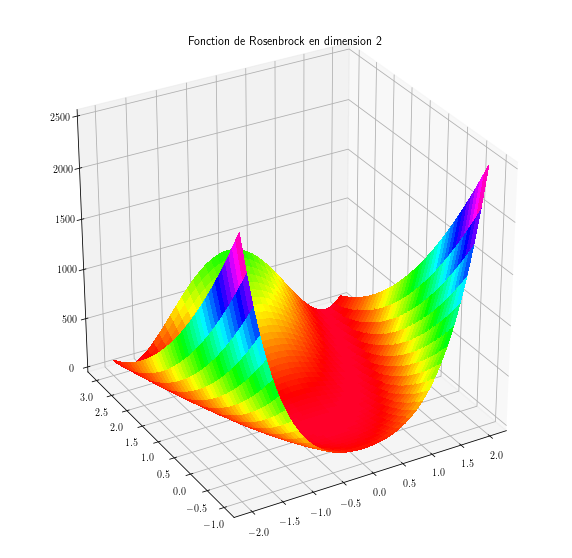

In [43]:
def rosen_dim2(x,y):
    return (100*(y-x**2)**2 + (1-x)**2)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

x1 , x2 = np.meshgrid(np.linspace(-2,2,201),np.linspace(-1,3,201))
z = rosen_dim2(x1,x2)


surf = ax.plot_surface(x1,x2,z, cmap=cm.gist_rainbow,
                       linewidth=0, antialiased=False)
ax.view_init(30, 240)
plt.title('Fonction de Rosenbrock en dimension 2')
plt.show()

In [53]:
def rosen(x):
   
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

def grad_rosen(x):
    grad = np.zeros_like(x)
    
    grad[1:-1]=-400*x[1:-1]*(x[2:]-x[1:-1]**2)-2*(1-x[1:-1])+200*(x[1:-1]-x[:-2]**2)
    grad[0]=-400*x[0]*(x[1]-x[0]**2)-2*(1-x[0])
    grad[-1]=200*(x[-1]-x[-2]**2)
    return grad
    

def Hess_rosen(x):
    
    N=len(x)
    
    diagonal=np.zeros_like(x)
    diagonal[0] = 1200*x[0]**2-400*x[1]+2
    diagonal[-1] = 200
    diagonal[1:-1] = 202 + 1200*x[1:-1]**2 - 400*x[2:]

    return sparse.diags([-400*x[:-1], diagonal, -400*x[:-1]], [-1, 0, 1], shape=(N,N))
    
#x_init=np.array([-1,1])   # Nesterov converge
x_init=np.array([1.3, 0.7, 0.8, 1.9, 1.2]) # Nesterov diverge
#x_init=np.random.randn(10)
sol_rosen=np.ones_like(x_init)

print('=================================')
print('Algorithme du gradient à pas fixe')
x_PasFixe_rosen, f_PasFixe, conv_PasFixe = gradientPasFixe(rosen,grad_rosen,x_init,0.001,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_rosen-x_PasFixe_rosen[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_rosen)[0]-1)

print('=================================')
print('Algorithme de Nesterov')
x_Nesterov_rosen, f_Nesterov, conv_Nesterov = gradientNesterov(rosen,grad_rosen,x_init,0.001,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_rosen-x_Nesterov_rosen[-1]))
print('Convergence =',conv_Nesterov)
print('Nombre d itérations = ',np.shape(x_Nesterov_rosen)[0]-1)

print('=================================')
print('Algorithme de Newton')
x_Newton_rosen, f_Newton, conv_Newton = Newton(rosen,grad_rosen,Hess_rosen,x_init,tol=1e-06,maxiter=200)
print('Erreur = ',np.linalg.norm(sol_rosen-x_Newton_rosen[-1]))
print('Convergence =',conv_Newton)
print('Nombre d itérations = ',np.shape(x_Newton_rosen)[0]-1)

print('=================================')
print('Algorithme du gradient à pas optimal')
x_PasOpt_rosen, f_PasOpt, conv_PasOpt = gradientPasOpt(rosen,grad_rosen,x_init,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_rosen-x_PasOpt_rosen[-1]))
print('Convergence =',conv_PasOpt)
print('Nombre d itérations = ',np.shape(x_PasOpt_rosen)[0]-1)

Algorithme du gradient à pas fixe
Erreur =  inf
Convergence = True
Nombre d itérations =  6
Algorithme de Nesterov
Erreur =  inf
Convergence = True
Nombre d itérations =  6
Algorithme de Newton
Erreur =  3.242292184520505
Convergence = True
Nombre d itérations =  18
Algorithme du gradient à pas optimal


/home/flore/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in square
  This is separate from the ipykernel package so we can avoid doing imports until
/home/flore/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in multiply
  
/home/flore/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
/home/flore/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in add
  
/home/flore/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':


Erreur =  1.6002521754034378e-06
Convergence = True
Nombre d itérations =  21809


## Remarque 3.3.9 du poly

On définit la fonctionnelle $J:\mathbb R^N \to \mathbb R$ par :

$$ J(v) = \frac{L}8 \left( (v_1-1)^2+\sum_{i=2}^p(v_i-v_{i-1})^2 + \sum_{i=p+1}^N v_i^2\right),$$
avec $p \le N$.

In [54]:
N=500
p=60
cte_L = 2

def Jpoly(x):
    return (cte_L/8)*((x[0]-1)**2+np.sum((x[1:p]-x[:p-1])**2)+np.sum(x[p:]**2))
                      

def grad_Jpoly(x):
    grad = np.zeros_like(x)
    
    grad[1:p-1]=(x[1:p-1]-x[:p-2])-(x[2:p]-x[1:p-1])
    grad[0]=(x[0]-1)-(x[1]-x[0])
    grad[p-1]=x[p-1]-x[p-2]
    grad[p:]=x[p:]
    return (cte_L/4)*grad
    

def Hess_Jpoly(x):
    
    diag=np.ones_like(x)
    diag[:p-1] = 2
                      
    ss_diag=np.zeros(N-1)
    ss_diag[:p-1]=-1
  
    return sparse.diags([cte_L/4*ss_diag, cte_L/4*diag, cte_L/4*ss_diag], [-1, 0, 1], shape=(N,N))




x_init=np.zeros(N) 

sol_poly=np.ones_like(x_init)
sol_poly[p:]=0

print('=================================')
print('Algorithme du gradient à pas fixe')
x_PasFixe_poly, f_PasFixe, conv_PasFixe = gradientPasFixe(Jpoly,grad_Jpoly,x_init,0.6,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_poly-x_PasFixe_poly[-1]))
print('Convergence =',conv_PasFixe)
print('Nombre d itérations = ',np.shape(x_PasFixe_poly)[0]-1)

print('=================================')
print('Algorithme du gradient à pas optimal')
x_PasOpt_poly, f_PasOpt, conv_PasOpt = gradientPasOpt(Jpoly,grad_Jpoly,x_init,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_poly-x_PasOpt_poly[-1]))
print('Convergence =',conv_PasOpt)
print('Nombre d itérations = ',np.shape(x_PasOpt_poly)[0]-1)

print('=================================')
print('Algorithme de Nesterov')
x_Nesterov_poly, f_Nesterov, conv_Nesterov = gradientNesterov(Jpoly,grad_Jpoly,x_init,0.6,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_poly-x_Nesterov_poly[-1]))
print('Convergence =',conv_Nesterov)
print('Nombre d itérations = ',np.shape(x_Nesterov_poly)[0]-1)


print('=================================')
print('Algorithme de Nesterov (fonctions fortement convexes)')
x_Nesterov2_poly, f_Nesterov2, conv_Nesterov2 = gradientNesterov2(Jpoly,grad_Jpoly,x_init,0.6,cte_L/16,cte_L,1e-6,50000)
print('Erreur = ',np.linalg.norm(sol_poly-x_Nesterov2_poly[-1]))
print('Convergence =',conv_Nesterov2)
print('Nombre d itérations = ',np.shape(x_Nesterov2_poly)[0]-1)

print('=================================')
print('Algorithme de Newton')
x_Newton_poly, f_Newton, conv_Newton = Newton(Jpoly,grad_Jpoly,Hess_Jpoly,x_init,tol=1e-06,maxiter=50000)
print('Erreur = ',np.linalg.norm(sol_poly-x_Newton_poly[-1]))
print('Convergence =',conv_Newton)
print('Nombre d itérations = ',np.shape(x_Newton_poly)[0]-1)




Algorithme du gradient à pas fixe
Erreur =  0.0029669738350870957
Convergence = True
Nombre d itérations =  38402
Algorithme du gradient à pas optimal
Erreur =  0.0027305323823815317
Convergence = True
Nombre d itérations =  23266
Algorithme de Nesterov
Erreur =  0.002966931087491375
Convergence = True
Nombre d itérations =  19197
Algorithme de Nesterov (fonctions fortement convexes)
Erreur =  0.002966749998971265
Convergence = True
Nombre d itérations =  16601
Algorithme de Newton
Erreur =  0.0
Convergence = True
Nombre d itérations =  2


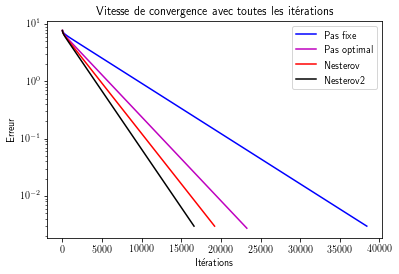

In [55]:
err_PasFixe_poly=np.linalg.norm(x_PasFixe_poly-sol_poly,axis=1)
err_PasOpt_poly=np.linalg.norm(x_PasOpt_poly-sol_poly,axis=1)
err_Nesterov_poly=np.linalg.norm(x_Nesterov_poly-sol_poly,axis=1)
err_Nesterov2_poly=np.linalg.norm(x_Nesterov2_poly-sol_poly,axis=1)

plt.figure()
plt.semilogy(err_PasFixe_poly,'-b')
plt.semilogy(err_PasOpt_poly,'-m')
plt.semilogy(err_Nesterov_poly,'-r')
plt.semilogy(err_Nesterov2_poly,'-k')
plt.legend(['Pas fixe','Pas optimal','Nesterov','Nesterov2'])
plt.title('Vitesse de convergence avec toutes les itérations')
plt.xlabel('Itérations')
plt.ylabel('Erreur')
plt.show()

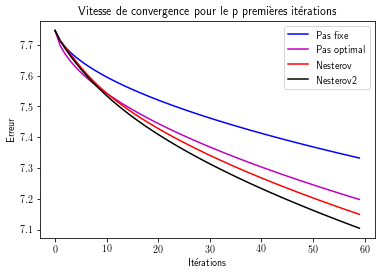

In [56]:

it_max=p

plt.figure()
plt.plot(err_PasFixe_poly[:it_max],'-b')
plt.plot(err_PasOpt_poly[:it_max],'-m')
plt.plot(err_Nesterov_poly[:it_max],'-r')
plt.plot(err_Nesterov2_poly[:it_max],'-k')
plt.legend(['Pas fixe','Pas optimal','Nesterov','Nesterov2'])
plt.title('Vitesse de convergence pour le p premières itérations')
plt.xlabel('Itérations')
plt.ylabel('Erreur')
plt.show()
